In [1]:
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.keras import layers, losses
import os
import time

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [8]:
datas = glob.glob('20201203/wifi/dataRssi_at_*.txt')

In [9]:
def getRotationMatrix(gra,m):
    Ax = gra[0]
    Ay = gra[1]
    Az = gra[2]
    Ex = m[0]
    Ey = m[1]
    Ez = m[2]
    Hx = Ey*Az - Ez*Ay
    Hy = Ez*Ax - Ex*Az
    Hz = Ex*Ay - Ey*Ax
    normH = np.sqrt(Hx*Hx + Hy*Hy + Hz*Hz)
    if normH < 0.1:
        return False
    invH = 1.0 / normH
    Hx *= invH
    Hy *= invH
    Hz *= invH
    invA = 1.0 / np.sqrt(Ax*Ax + Ay*Ay + Az*Az)
    Ax *= invA
    Ay *= invA
    Az *= invA
    Mx = Ay*Hz - Az*Hy
    My = Az*Hx - Ax*Hz
    Mz = Ax*Hy - Ay*Hx
    R = np.array([Hx,Hy,Hz,Mx,My,Mz,Ax,Ay,Az])
    return R

In [11]:
train_data = []
train_label = []
for data in datas:
    load_data = np.loadtxt(data)#f.read()
    gras = load_data[:,-3:]/100
    ms = load_data[:,-15:-12]/100
    for gra,m in zip(gras,ms):
        R = getRotationMatrix(gra,m)
        gm = np.dot(R.reshape(3,3),m.reshape(3,1))
        train_data.append(gm)
        train_label.append(data.split("/")[-1].split("_")[-1].split(".")[0])


train_data = np.array(train_data).astype('float32')
train_data = train_data.reshape(-1,3)
train_data = (train_data - train_data.mean(axis=0)) / train_data.std(axis = 0)
train_label = np.array(pd.get_dummies(train_label)).astype('float32')
#train_label = train_label.reshape(len(train_label),1)
train_val_split = np.random.rand(len(train_data)) < 0.70
train_x = train_data[train_val_split]
train_y = train_label[train_val_split]
val_x = train_data[~train_val_split]
val_y = train_label[~train_val_split]
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = train_x.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_x)).batch(len(val_x))


In [12]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',shape=[self.dense.input_shape[-1]],initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [13]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
#with mirrored_strategy.scope():

input = tf.keras.layers.Input(shape=(3), name='input_layer1')
#flatten = tf.keras.layers.Flatten()(input)
dense1 = tf.keras.layers.Dense(8, activation='relu')
dense2 = tf.keras.layers.Dense(12, activation='relu')
dense3 = tf.keras.layers.Dense(16, activation='relu')
model_encoder = dense1(input)
model_encoder = dense2(model_encoder)
model_encoder = dense3(model_encoder)
model_down = tf.keras.Model(inputs=[input], outputs=model_encoder,name = "encoder")#input1, input2,input3,input4,input5,input6,input7,input8,input9,input10
#model_down.summary()
#input_encoder = tf.keras.layers.Input(shape=(15), name='input_layer2')
input2 = tf.keras.layers.Input(shape=(16), name='input_layer2')
model_decoder = DenseTranspose(dense3, activation = 'relu')(input2)
model_decoder = DenseTranspose(dense2, activation = 'relu')(model_decoder)
model_decoder = DenseTranspose(dense1, activation = 'relu')(model_decoder)
model_up = tf.keras.Model(inputs=[input2], outputs=model_decoder,name = "decoder")

#model_encoder_decoder.summary()
input3 = tf.keras.layers.Input(shape=(16), name='input_layer3')
model_ann = tf.keras.layers.Dense(16, activation='relu')(input3)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
#model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
#model_ann = tf.keras.layers.Dense(16, activation='relu')(model_ann)
#model_ann = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)(model_ann)
model_ann = tf.keras.layers.Dense(50, activation='softmax')(model_ann)
model_ANN = tf.keras.Model(inputs=[input3], outputs=model_ann,name = "ann")

input_full = tf.keras.layers.Input(shape=(3), name='input_layer4')
encoder_out = model_down(input_full)
decoder_out = model_up(encoder_out)
ann_out = model_ANN(encoder_out)
#model_encoder_decoder_ann = tf.keras.Model(inputs=[input_full],outputs=[decoder_out],name = 'encoder_decoder_ann')
model_encoder_decoder_ann = tf.keras.Model(inputs=[input_full],outputs=[decoder_out,ann_out],name = 'encoder_decoder_ann')
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=1e-5)

In [14]:
model_encoder_decoder_ann.summary()

Model: "encoder_decoder_ann"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer4 (InputLayer)       [(None, 3)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 16)           348         input_layer4[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 3)            371         encoder[1][0]                    
__________________________________________________________________________________________________
ann (Model)                     (None, 50)           1666        encoder[1][0]                    
Total params: 2,037
Trainable params: 2,037
Non-trainable params: 0
____________

In [15]:
len(model_encoder_decoder_ann.trainable_variables)

17

In [16]:
for i in range(17):
    print(model_encoder_decoder_ann.trainable_variables[i].shape)

(3, 8)
(8,)
(8, 12)
(12,)
(12, 16)
(16,)
(12,)
(8,)
(3,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 50)
(50,)


In [17]:
shared_vars = model_encoder_decoder_ann.trainable_variables[:6]
decode_vars = model_encoder_decoder_ann.trainable_variables[6:9]
ann_vars = model_encoder_decoder_ann.trainable_variables[9:]

In [18]:
def model_loss(output,t_x,t_y):
    #print("in loss")
    output_AE , output_label = output
    #output_AE = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(t_x,output_AE)
    ann_loss =losses.categorical_crossentropy(t_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    
    return AE_loss,ann_loss

In [19]:
learning_rate_A = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-4, decay_steps=5000, decay_rate=0.9)
optimizer_A = tf.optimizers.SGD(learning_rate=learning_rate_A , momentum=1e-5)
learning_rate_B = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.8)
optimizer_B = tf.optimizers.Adam(learning_rate=1e-3)#learning_rate_B)

In [20]:
#@tf.function

def train_step(t_x,t_y):
  
    with tf.GradientTape() as AE_tape,tf.GradientTape() as ANN_tape:
        output = model_encoder_decoder_ann(t_x, training=True)
        #AE_loss = model_loss(output,t_o,t_y)
        AE_loss,ANN_loss = model_loss(output,t_x,t_y)
        #gradients = tape.gradient(total_loss, shared_vars+decode_vars)
        #optimizer_A.apply_gradients(zip(gradients, shared_vars+decode_vars))

    if np.random.rand() < 0.5:
        #print("AE")
        gradients_AE = AE_tape.gradient(AE_loss, shared_vars+decode_vars)
        #gradients_AE = [tf.clip_by_value(g, -1,1) for g in gradients_AE]

        #print("AE gradient : ",gradients_AE)
        optimizer_A.apply_gradients(zip(gradients_AE, shared_vars+decode_vars))
    
    else:
        #print("ANN")
        gradients_ANN = ANN_tape.gradient(ANN_loss, shared_vars+ann_vars)
        #print("ANN gradient : ",gradients_ANN)
        #gradients_ANN = [tf.clip_by_value(g, -1,1) for g in gradients_ANN] 
        optimizer_B.apply_gradients(zip(gradients_ANN, shared_vars+ann_vars))
    
    return np.array(AE_loss).mean(),np.array(ANN_loss).mean()

In [21]:
checkpoint_dir = './magnetic_checkpoints/checkpoints_1222'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_dropout_model_{epoch}")
checkpoint = tf.train.Checkpoint(optimizerA=optimizer_A,
                                 optimizerB=optimizer_B,
                                 model_encoder_decoder_ann=model_encoder_decoder_ann,
                                 model_down=model_down)

In [22]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model_encoder_decoder.optimizer.lr.numpy()))

In [23]:
def validation(v_x,v_y):
    output = model_encoder_decoder_ann(v_x)
    #output_AE = output
    output_AE , output_label = output
    mse = losses.MeanSquaredError()
    AE_loss = mse(v_x,output_AE)
    ann_loss = losses.categorical_crossentropy(v_y,output_label)
    total_loss = AE_loss*100 + ann_loss
    #print(output_label[200])
    #print(v_y[200])
    #print(ann_loss)
    #print("AE loss : {},".format(np.array(AE_loss).mean()))
    print("AE loss : {}, ANN loss : {}, Total loss : {}".format(np.array(AE_loss).mean(),np.array(ann_loss).mean(),np.array(total_loss).mean()))

In [24]:
val_x.shape

(4235, 3)

In [25]:
def train(epochs):
  for epoch in range(epochs):
    start = time.time()
    all_AE = []
    all_ANN =[]
    for x,y in train_dataset:
        #AE_loss = train_step(x,y)
        AE_loss,ANN_loss = train_step(x,y)
        all_AE.append(AE_loss)
        all_ANN.append(ANN_loss)
    #print("train AE loss : {}".format(np.array(all_AE).mean()))
    print("train AE loss : {}, train ANN loss : {}".format(np.array(all_AE).mean(),np.array(all_ANN).mean()))
    validation(val_x,val_y)
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("learning rate A : ",optimizer_A._decayed_lr(tf.float32))
    print("learning rate B : ",optimizer_B._decayed_lr(tf.float32))
    print(f'Time for epoch {epoch + 1} is {time.time() - start:.4f} sec')


In [26]:
train(2000)

train AE loss : 0.9160338044166565, train ANN loss : 3.9122133255004883
AE loss : 0.9196826815605164, ANN loss : 3.9094488620758057, Total loss : 95.87772369384766
learning rate A :  tf.Tensor(1e-04, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time for epoch 1 is 0.5819 sec
train AE loss : 0.9168521165847778, train ANN loss : 3.911435127258301
AE loss : 0.9196534156799316, ANN loss : 3.9094483852386475, Total loss : 95.87479400634766
learning rate A :  tf.Tensor(9.999789e-05, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time for epoch 2 is 0.0975 sec
train AE loss : 0.9168226718902588, train ANN loss : 3.911229133605957
AE loss : 0.9204185605049133, ANN loss : 3.9082894325256348, Total loss : 95.95014953613281
learning rate A :  tf.Tensor(9.999789e-05, shape=(), dtype=float32)
learning rate B :  <tf.Variable 'Adam/learning_rate:0' shape=() dty

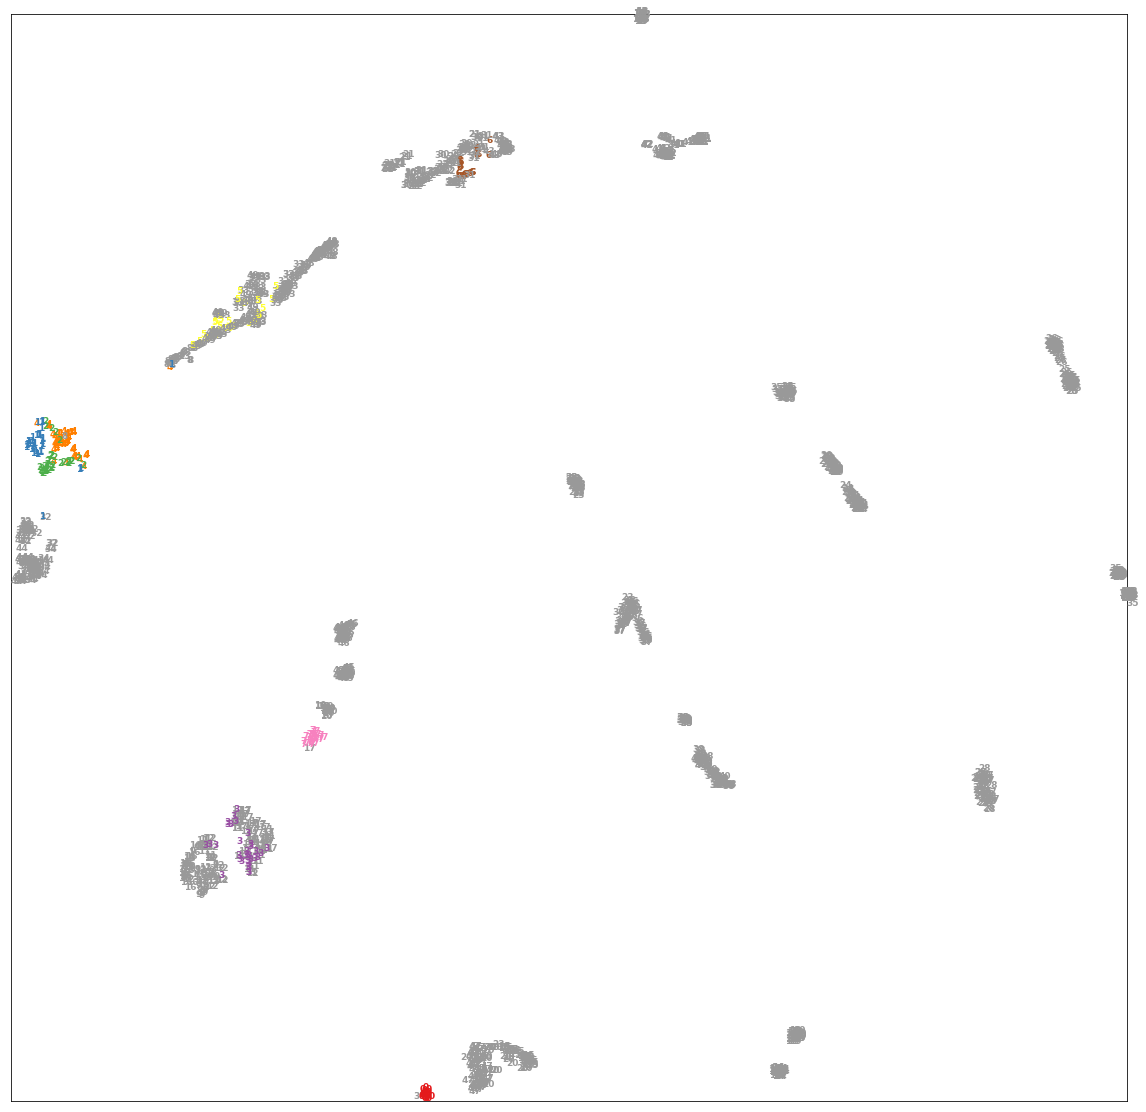

In [27]:
val_latent = model_down(val_x)
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
train_val_split = np.random.rand(len(val_latent)) < 0.4
X_tsne = manifold.TSNE(n_components=2, init='pca', n_iter=5000, method='exact').fit_transform(val_latent[train_val_split])
y = val_y[train_val_split].argmax(axis=1).reshape([-1,1])
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i,0]), color=plt.cm.Set1(y[i,0]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.savefig("result/mag_pca_latent16")
plt.show()

In [44]:
y = val_y[train_val_split].argmax(axis=1).reshape([-1,1])

In [45]:
y.shape

(143, 1)

In [46]:
model_encoder_decoder_ann.weights[0][0]

<tf.Tensor: id=1112230, shape=(8,), dtype=float32, numpy=
array([ 0.06707124, -0.06958992, -0.08077073,  0.07173584, -0.00723271,
       -0.05953319,  0.11224787,  0.03083349], dtype=float32)>

In [47]:
model_down.weights[0][0]

<tf.Tensor: id=1112235, shape=(8,), dtype=float32, numpy=
array([ 0.06707124, -0.06958992, -0.08077073,  0.07173584, -0.00723271,
       -0.05953319,  0.11224787,  0.03083349], dtype=float32)>